In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# additional imports
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
# number of classes
K = len(set(y_train.flatten()))
print("number of classes:", K)

number of classes: 10


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
#x_train = x_train/255
#x_test = x_test/255
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)
print("x_train.shape:", x_train.shape)
print("y_train_cat.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train_cat.shape (50000, 1)


In [7]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


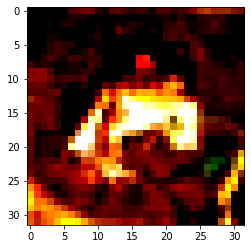

In [8]:
# FROG
plt.imshow(x_train[0])

In [9]:
x_train.shape[1:]

(32, 32, 3)

In [10]:
x_train[0]

array([[[-0.96192505, -0.91515971, -0.89957127],
        [-1.21134019, -1.16457485, -1.1801633 ],
        [-1.10222107, -1.13339796, -1.21134019],
        ...,
        [ 0.58133111,  0.17603151, -0.19809119],
        [ 0.48780043,  0.06691239, -0.29162187],
        [ 0.42544665,  0.05132394, -0.27603342]],

       [[-1.63222823, -1.56987445, -1.56987445],
        [-1.88164337, -1.88164337, -1.88164337],
        [-1.60105134, -1.7569358 , -1.88164337],
        ...,
        [ 0.0357355 , -0.50986012, -1.02427884],
        [-0.02661829, -0.58780235, -1.10222107],
        [ 0.02014705, -0.52544856, -0.99310194]],

       [[-1.49193222, -1.50752066, -1.554286  ],
        [-1.63222823, -1.77252425, -1.88164337],
        [-1.11780951, -1.46075533, -1.7569358 ],
        ...,
        [-0.04220673, -0.5722139 , -1.10222107],
        [-0.01102984, -0.5722139 , -1.10222107],
        [-0.18250275, -0.74368681, -1.22692863]],

       ...,

       [[ 1.36075341,  0.76839246, -0.38515255],
        [ 1

In [38]:
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-7, verbose = 1, patience=5)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=30)
#mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_accuracy', mode = 'max', factor=0.5, min_lr=1e-7, verbose = 1, patience=10)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience=50)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)

In [39]:
# build model
def build_model(lr = 0, dc = 0, dr = 0):
    model = Sequential(name = 'CNN_cifar10')
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = optimizers.Adam(lr = lr, decay = dc)
    #opt = optimizers.SGD(lr = lr, momentum = mt)
    #opt = optimizers.RMSprop(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [40]:
model = build_model(lr = 0.001, dc = 1e-5, dr = 0.5)
#model = build_model(lr = 0.01, mt = 0.9, dr = 0.5)
#model = build_model(lr = 0.0003, dc = 1e-6, dr = 0.5)

In [41]:
model.summary()

Model: "CNN_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        

In [42]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
datagen.fit(x_train)

In [43]:
# run model
model.fit_generator(datagen.flow(x_train, y_train_cat, batch_size = 64),
                                 validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 400, verbose = 1,
                                 callbacks = [rlr, es, mc])


Epoch 1/400
780/781 [============================>.] - ETA: 0s - loss: 1.8103 - accuracy: 0.4198
Epoch 00001: val_accuracy improved from -inf to 0.57880, saving model to cnn_best_model.h5
781/781 [==============================] - 27s 35ms/step - loss: 1.8098 - accuracy: 0.4199 - val_loss: 1.3035 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 2/400
781/781 [==============================] - ETA: 0s - loss: 1.2976 - accuracy: 0.5699
Epoch 00002: val_accuracy improved from 0.57880 to 0.64320, saving model to cnn_best_model.h5
781/781 [==============================] - 27s 34ms/step - loss: 1.2976 - accuracy: 0.5699 - val_loss: 1.1312 - val_accuracy: 0.6432 - lr: 0.0010
Epoch 3/400
780/781 [============================>.] - ETA: 0s - loss: 1.1249 - accuracy: 0.6370
Epoch 00003: val_accuracy improved from 0.64320 to 0.69860, saving model to cnn_best_model.h5
781/781 [==============================] - 26s 33ms/step - loss: 1.1248 - accuracy: 0.6370 - val_loss: 0.9649 - val_accuracy: 0.6986 - lr:

In [44]:
ls

cnn_best_model.h5  sample_data/


In [45]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()
    

In [46]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


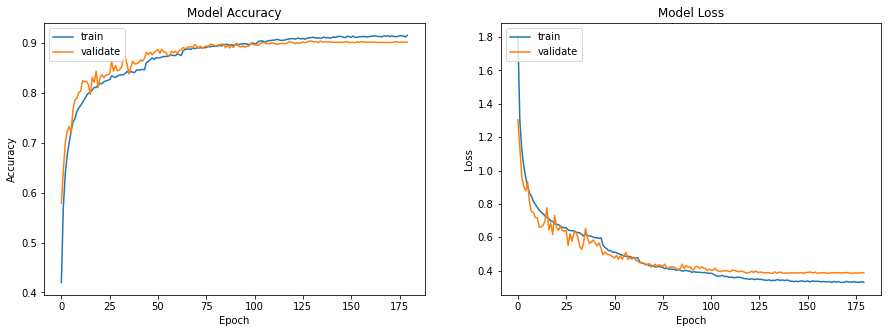

In [47]:
plotmodelhistory(model.history)

Confusion matrix, without normalization
[[903  15  19   1   4   0   5   7  27  19]
 [  3 958   0   0   0   0   2   0   3  34]
 [ 24   0 869  15  26  16  33  14   1   2]
 [  8   6  28 752  30  75  60  19   6  16]
 [  2   1  15  14 914   4  30  17   2   1]
 [  5   1  13  82  27 809  23  33   1   6]
 [  4   3   9   7   4   0 969   1   1   2]
 [  3   1   3  11  18  12   7 940   1   4]
 [ 20   8   2   2   0   0   2   0 944  22]
 [  4  25   1   2   1   0   0   1   5 961]]


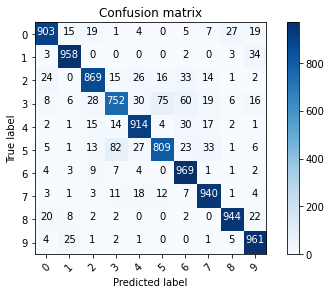

In [48]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [49]:
# label mapping
labels = '''airplane
      automobile
      bird
      cat
      deer
      dog
      frog
      horse
      ship
      truck'''.split()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True label: airplane, Predicted: ship')

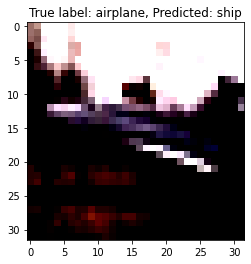

In [50]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test.flatten())[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s, Predicted: %s" % (labels[y_test.flatten()[i]], labels[p_test[i]]))
